# **Problem Statement: Identifiying Bird species from their calls** 🐦

Hawaii, the extinction capital of the world has lost 68% of its bird species, the consequences of which can harm the food chain.

Researchers have been using population monitoring to understand how the native birds react to the changes in environment and conservation efforts.

But the issue is that the remainder of these birds are isolated in difficult-to-access, high elevation habitats which makes it difficult to monitor them physically.

Therefore, scientists have been turning towards bioacoustic monitoring which could provide a passive, low labor, and cost-effective strategy for studying endangered bird populations.

**So the task in hand is to develop a model that can process continuous audio data and then acoustically recognize the species.**

## Dataset

Dataset has been generated and distributed by the Cornell Lab of Ornithology's K. Lisa Yang Center for Conservation Bioacoustics (KLY-CCB).
The audio recording have been sourced from [xeno-canto.org](https://xeno-canto.org/).

[Link to dataset](https://https://www.kaggle.com/competitions/birdclef-2022/data)





# **Metadata**

**train_metadata.csv**- A wide range of metadata is provided for the training data. The most directly relevant fields are:

`primary_label` - a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.


`secondary_labels:` Background species as annotated by the recordist. An empty list does not mean that no background birds are audible.


`author `- the eBird user who provided the recording.


`filename`: the associated audio file.


`rating`: Float value between 0.0 and 5.0 as an indicator of the quality rating on Xeno-canto and the number of background species, where 5.0 is the highest and 1.0 is the lowest. 0.0 means that this recording has no user rating yet.

**train_audio/** - The bulk of the training data consists of short recordings of individual bird calls generously uploaded by users of xenocanto.org. These files have been downsampled to 32 kHz where applicable to match the test set audio and converted to the ogg format.

**test.csv**- Metadata for the test set.

`row_id` - A unique identifier for the row.

`file_id` - A unique identifier for the audio file.

`bird` - The ebird code for the row. There is one row for each of the scored species per 5 second window per audio file.

`end_time` - The last second of the 5 second time window (5, 10, 15, etc).

**eBird_Taxonomy_v2021.csv** - Data on the relationships between different species.

**scored_birds.json** - The subset of the species in the dataset that are scored.


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import librosa as lb
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from fastai.vision.all import *
import torchaudio
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from IPython.display import Image
from PIL import Image
import librosa.display as ld
from IPython.display import Audio
import seaborn as sns
import folium
from folium.plugins import HeatMap,MarkerCluster
from torch.utils.data import DataLoader, Dataset, random_split
import noisereduce as nr
import cv2

# **Loading metadata and audio**

In [ ]:
train_audio = glob.glob('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/*/*.ogg')
train_audio[0]

'/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/golphe/XC265846.ogg'

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_metadata.csv')
train_df

primary_label                secondary_labels  \
0           afrsil1                              []   
1           afrsil1  ['houspa', 'redava', 'zebdov']   
2           afrsil1                              []   
3           afrsil1                              []   
4           afrsil1                              []   
...             ...                             ...   
14847        zebdov                              []   
14848        zebdov                              []   
14849        zebdov                              []   
14850        zebdov                              []   
14851        zebdov                              []   

                                     type  latitude  longitude  \
0                 ['call', 'flight call']   12.3910    -1.4930   
1                                ['call']   19.8801  -155.7254   
2                        ['call', 'song']   16.2901   -16.0321   
3                  ['alarm call', 'call']   17.0922    54.2958   
4                         ['flight call']   21.4581  -157.7252   
...                                   ...       ...        ...   
14847                   ['adult', 'song']   22.6499   120.2872   
14848  ['adult', 'sex uncertain', 'song']    1.4168   103.7287   
14849  ['adult', 'call', 'sex uncertain']    1.4347   103.7043   
14850                            ['song']    3.3508   101.2451   
14851                            ['song']    3.3508   101.2451   

        scientific_name         common_name              author  \
0       Euodice cantans  African Silverbill           Bram Piot   
1       Euodice cantans  African Silverbill            Dan Lane   
2       Euodice cantans  African Silverbill           Bram Piot   
3       Euodice cantans  African Silverbill      Oscar Campbell   
4       Euodice cantans  African Silverbill       Ross Gallardy   
...                 ...                 ...                 ...   
14847  Geopelia striata          Zebra Dove  Jerome Chie-Jen Ko   
14848  Geopelia striata          Zebra Dove       Kim Chuah Lim   
14849  Geopelia striata          Zebra Dove       Kim Chuah Lim   
14850  Geopelia striata          Zebra Dove    Jelle Scharringa   
14851  Geopelia striata          Zebra Dove    Jelle Scharringa   

                                                         license  rating  \
0      Creative Commons Attribution-NonCommercial-ShareAlike 3.0     2.5   
1      Creative Commons Attribution-NonCommercial-ShareAlike 4.0     3.5   
2      Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
3      Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
4      Creative Commons Attribution-NonCommercial-ShareAlike 4.0     3.0   
...                                                          ...     ...   
14847  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     2.5   
14848  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
14849  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
14850  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     2.5   
14851  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     2.5   

        time                                url              filename  
0      08:00  https://www.xeno-canto.org/125458  afrsil1/XC125458.ogg  
1      08:30  https://www.xeno-canto.org/175522  afrsil1/XC175522.ogg  
2      11:30  https://www.xeno-canto.org/177993  afrsil1/XC177993.ogg  
3      11:00  https://www.xeno-canto.org/205893  afrsil1/XC205893.ogg  
4      16:30  https://www.xeno-canto.org/207431  afrsil1/XC207431.ogg  
...      ...                                ...                   ...  
14847  08:36  https://www.xeno-canto.org/629769   zebdov/XC629769.ogg  
14848  08:00  https://www.xeno-canto.org/642415   zebdov/XC642415.ogg  
14849  09:00  https://www.xeno-canto.org/665873   zebdov/XC665873.ogg  
14850  11:15  https://www.xeno-canto.org/666194   zebdov/XC666194.ogg  
14851  10:00  https://www.xeno-canto.org/6

# **Metadata EDA and preprocessing**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          14852 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.5+ MB


### Finding the number of bird species in the dataset

In [ ]:
print("There are " + str(len(train_df.primary_label.unique())) + " unique species in the dataset")

There are 152 unique species in the dataset


In [ ]:
train_df.common_name.unique()

array(['African Silverbill', 'Akekee', 'Hawaii Akepa', 'Akiapolaau',
       'Akikiki', 'American Wigeon', 'Anianiau', 'Apapane', 'Arctic Tern',
       'Band-rumped Storm-Petrel', 'Black-crowned Night-Heron',
       'Belted Kingfisher', 'Black-bellied Plover', 'Black-necked Stilt',
       'Black-winged Petrel', 'Black Francolin', 'Black Noddy',
       "Bonaparte's Gull", 'Brant', 'Brown Booby', 'Brown Noddy',
       'Barn Owl', 'Bristle-thighed Curlew', 'Buff-breasted Sandpiper',
       'Bufflehead', "Bulwer's Petrel", 'Burrowing Parakeet',
       'Blue-winged Teal', 'Cackling Goose', 'California Quail',
       'Canada Goose', 'Canvasback', 'Caspian Tern', 'Cattle Egret',
       'Chestnut-bellied Sandgrouse', 'Chestnut Munia', 'Chukar',
       'Cinnamon Teal', 'Common Gallinule', 'Common Myna',
       'Indian Peafowl', 'Common Sandpiper', 'Common Waxbill',
       "Cook's Petrel", 'Akohekohe', 'Dunlin', 'Hawaii Elepaio',
       "Erckel's Francolin", 'Eurasian Wigeon', "Franklin's Gull",


### Dropping unecessary columms

In [ ]:
train_df.drop(['author', 'license', 'url', 'time'], axis = 1)

primary_label                secondary_labels  \
0           afrsil1                              []   
1           afrsil1  ['houspa', 'redava', 'zebdov']   
2           afrsil1                              []   
3           afrsil1                              []   
4           afrsil1                              []   
...             ...                             ...   
14847        zebdov                              []   
14848        zebdov                              []   
14849        zebdov                              []   
14850        zebdov                              []   
14851        zebdov                              []   

                                     type  latitude  longitude  \
0                 ['call', 'flight call']   12.3910    -1.4930   
1                                ['call']   19.8801  -155.7254   
2                        ['call', 'song']   16.2901   -16.0321   
3                  ['alarm call', 'call']   17.0922    54.2958   
4                         ['flight call']   21.4581  -157.7252   
...                                   ...       ...        ...   
14847                   ['adult', 'song']   22.6499   120.2872   
14848  ['adult', 'sex uncertain', 'song']    1.4168   103.7287   
14849  ['adult', 'call', 'sex uncertain']    1.4347   103.7043   
14850                            ['song']    3.3508   101.2451   
14851                            ['song']    3.3508   101.2451   

        scientific_name         common_name  rating              filename  
0       Euodice cantans  African Silverbill     2.5  afrsil1/XC125458.ogg  
1       Euodice cantans  African Silverbill     3.5  afrsil1/XC175522.ogg  
2       Euodice cantans  African Silverbill     4.0  afrsil1/XC177993.ogg  
3       Euodice cantans  African Silverbill     4.0  afrsil1/XC205893.ogg  
4       Euodice cantans  African Silverbill     3.0  afrsil1/XC207431.ogg  
...                 ...                 ...     ...                   ...  
14847  Geopelia striata          Zebra Dove     2.5   zebdov/XC629769.ogg  
14848  Geopelia striata          Zebra Dove     4.0   zebdov/XC642415.ogg  
14849  Geopelia striata          Zebra Dove     4.0   zebdov/XC665873.ogg  
14850  Geopelia striata          Zebra Dove     2.5   zebdov/XC666194.ogg  
14851  Geopelia striata          Zebra Dove     2.5   zebdov/XC666195.ogg  

[14852 rows x 9 columns]

### Most recorded species

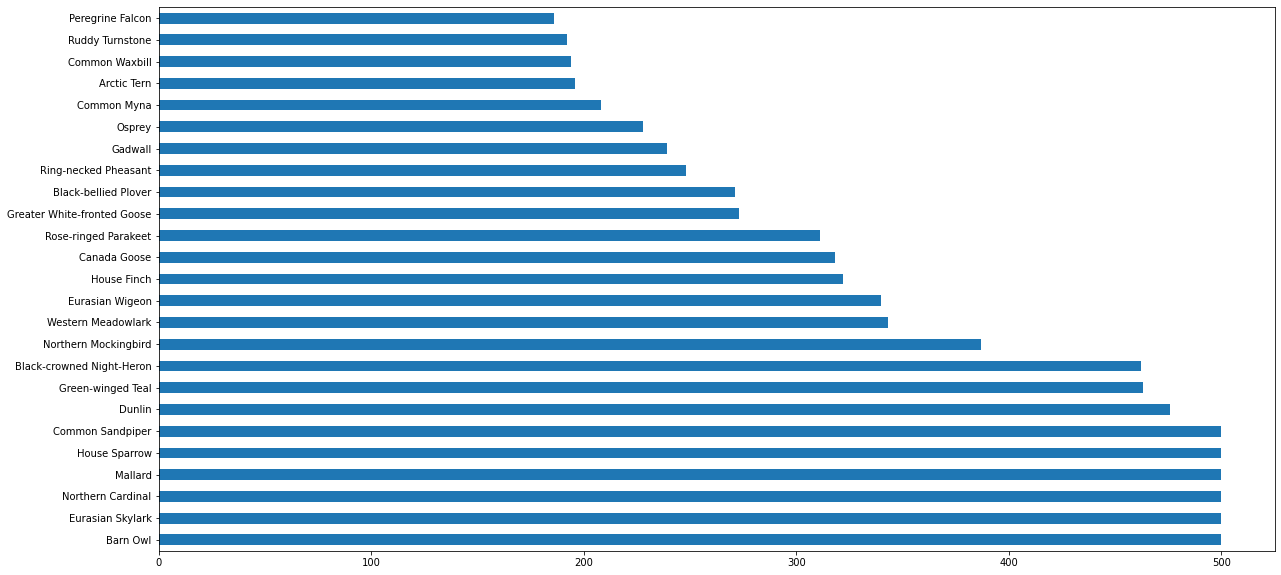

In [ ]:
top_birds = train_df['common_name'].value_counts().sort_values(ascending=False)[:25]
plt.figure(figsize=(20,10))
top_birds.plot.barh()
plt.show()

### Locations where most recordings were taken

In [ ]:
m1 = folium.Map(location=(train_df.latitude.mean(),train_df.longitude.mean()),zoom_start = 4, min_zoom=3,max_zoom=7)
h_map = HeatMap(data=train_df[['latitude','longitude']],
                radius=4,
                blur=2).add_to(m1)
m1

# **Audio EDA**

### Defining functions for Generating waveforms and Melspectrograms (feature extraction)

In [ ]:
class config:
  N_FFT = 2048
  HOP_LEN = 1024
  SAMPLE_RATE = 22050
  DURATION = 5
  

In [ ]:
'''
Function for extracting waveform and sample rate of audio.

Any audio recording has 2 characteristics: Smaple Rate and Waveform.

Input: path to audio file
Output: waveform, sample_rate
'''
def plot_waveform(path):
  waveform, sample_rate = torchaudio.load(path)
  plt.figure()
  plt.plot(waveform.t().numpy())

In [ ]:
def saveMel(signal, sr, directory):
  
    N_FFT = 1024         
    HOP_SIZE = 1024      
    N_MELS = 128          
    WIN_SIZE = 1024      
    WINDOW_TYPE = 'hann' 
    FEATURE = 'mel'      
    FMIN = 1400

    fig = plt.figure(1,frameon=False)
    fig.set_size_inches(6,6)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    S = librosa.feature.melspectrogram(y=signal, sr=sr,
                                        n_fft=N_FFT,
                                        hop_length=HOP_SIZE, 
                                        n_mels=N_MELS, 
                                        htk=True, 
                                        fmin=FMIN, 
                                        fmax=sr/2) 
    librosa.display.specshow(librosa.power_to_db(S**2,ref=np.max), fmin=FMIN) 

    fig.savefig(directory)
    plt.ioff()
    fig.clf()
    ax.cla()
    plt.clf()
    plt.close('all')
   

In [ ]:
size = {'desired': 5, # [seconds]
        'minimum': 4, # [seconds]
        'stride' : 0
}
step=1
def audio_proc(audiopath, dest):

  # signal, sr = librosa.load(audiopath)

  signal, sr = torchaudio.load(audiopath)
  num_samples = config.SAMPLE_RATE * config.DURATION


  effects = [
      ["lowpass", "-1", "300"],

      ["rate", f"{sr}"]

  ]

  # Apply effects
  signal, sr = torchaudio.sox_effects.apply_effects_tensor(signal, sr, effects)

  signal = np.array(signal) 
  signal = np.squeeze(signal)

  step = (size['desired']-size['stride'])*sr # length of step between two cuts in seconds
  
  nr=0;
  melpaths = []
  for start, end in zip(range(0,len(signal),step),range(size['desired']*sr,len(signal),step)):
      # cut file and save each piece
      nr=nr+1
      # save the file if its length is higher than minimum
      if end-start > size['minimum']*sr:
        correction = "_"+str(nr)+".png"

        dest = str(dest)
        
        melpath = dest.replace('.png', correction)
       
        print(melpath + '---')
        saveMel(signal[start:end], sr ,melpath)
        melpaths.append(melpath)

  return melpaths

        

In [ ]:
Path('/content/drive/MyDrive/spectograms_new/train_img').mkdir(parents=True, exist_ok=True)
Path('/content/drive/MyDrive/spectograms_new/test_img').mkdir(parents=True, exist_ok=True)

In [ ]:
'''
Function for saving melspectograms as images

'''

def create_image(filename, train_df):
  
    path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + filename
    specie_type, name = filename.split('/')
    name, ext = name.split('.')

    

    if specie_type in train_df.primary_label.unique():
  
        Path('/content/drive/MyDrive/spectograms_new/train_img/{}'.format(specie_type)).mkdir(parents=True, exist_ok=True)
        dest = Path('/content/drive/MyDrive/spectograms_new/train_img/{}'.format(specie_type))/f'{name}.png'
    else:
         dest = Path('/content/drive/MyDrive/spectograms_new/test_img')/f'{name}.png'
    
    
    final_dests = audio_proc(path, dest)
    
    return final_dests, specie_type

In [ ]:
'''
Function for plotting melspectograms

'''
def plot_spectrogram(path, sr=None):
   
    signal,sr=librosa.load(path,sr=sr)

    fig,ax=plt.subplots(figsize=(16,6))
    M = librosa.feature.melspectrogram(y=signal, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = ld.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
    plt.colorbar(img)
    ax.set(title=f'Mel spectrogram')
    plt.show()

# Audio and Spectograms for some of the bird species



> ## Yellow-fronted Canary



In [ ]:

row = train_df[train_df['common_name']=='Yellow-fronted Canary'].sort_values(by='rating',ascending=False).iloc[0]
path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + row['filename']
Audio(path)

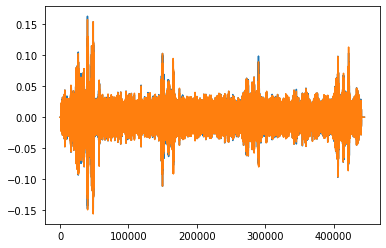

In [ ]:
plot_waveform(path)

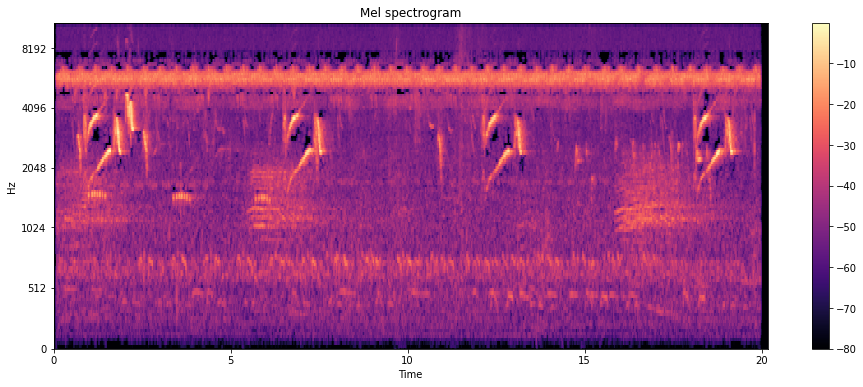

In [ ]:
plot_spectrogram(path)

> ## Zebra Dove

In [ ]:
row = train_df[train_df['common_name']=='Zebra Dove'].sort_values(by='rating',ascending=False).iloc[0]
path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + row['filename']
Audio(path)

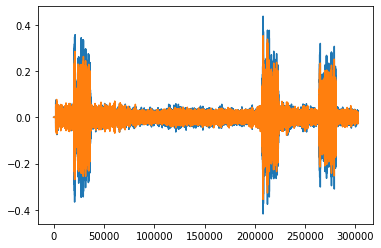

In [ ]:
plot_waveform(path)

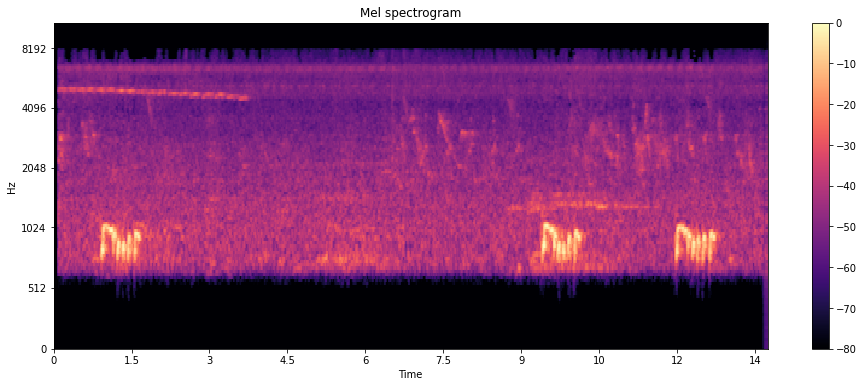

In [ ]:
plot_spectrogram(path)

> ## Pectoral Sandpiper

In [ ]:
row = train_df[train_df['common_name']=='Pectoral Sandpiper'].sort_values(by='rating',ascending=False).iloc[0]
path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + row['filename']
Audio(path)

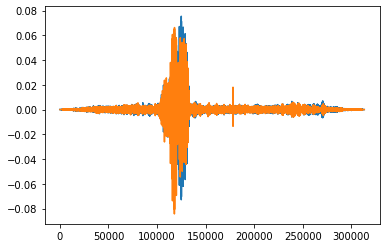

In [ ]:
plot_waveform(path)

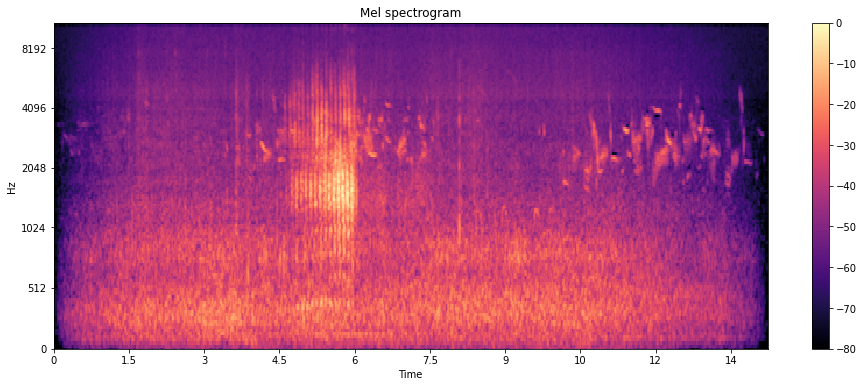

In [ ]:
plot_spectrogram(path)

> ## Snow Goose

In [ ]:
row = train_df[train_df['common_name']=='Snow Goose'].sort_values(by='rating',ascending=False).iloc[0]
path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + row['filename']
Audio(path)

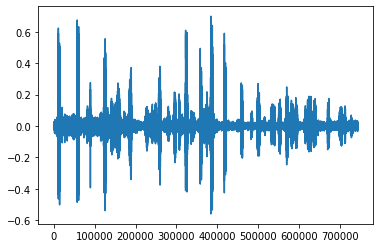

In [ ]:
plot_waveform(path)

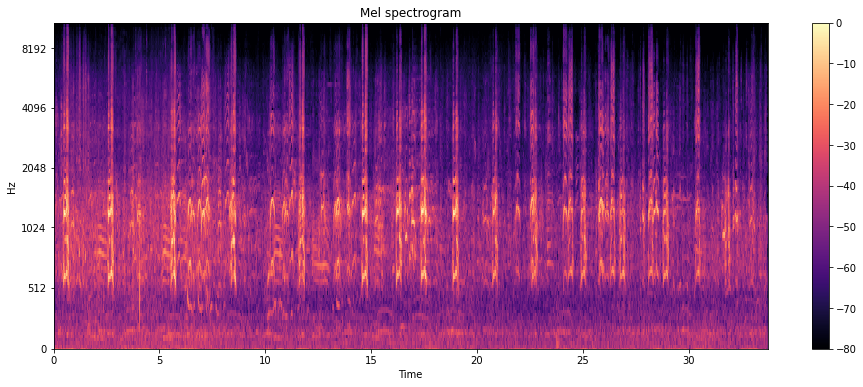

In [ ]:
plot_spectrogram(path)

> ## Laughing Gull

In [ ]:
row = train_df[train_df['common_name']=='Laughing Gull'].sort_values(by='rating',ascending=False).iloc[0]
path = '/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/' + row['filename']
Audio(path)

'/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_audio/laugul/XC651128.ogg'

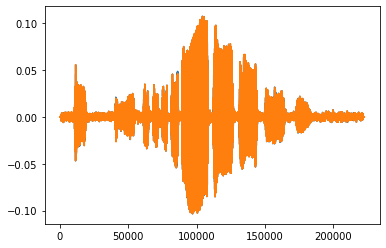

In [ ]:
plot_waveform(path)

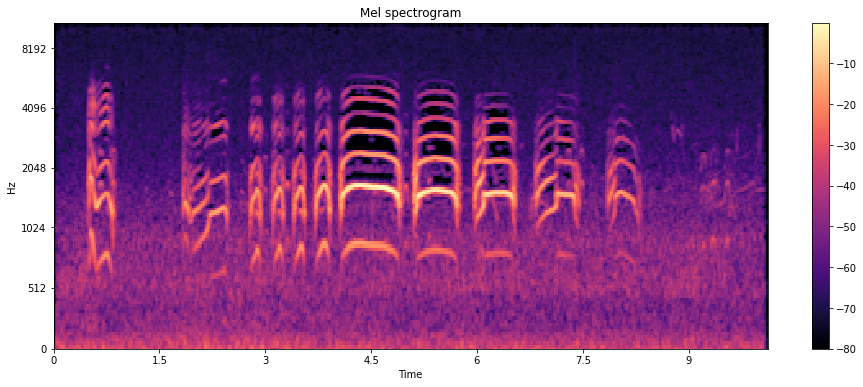

In [ ]:
plot_spectrogram(path)

# For simplicity, I will be only considering the top occuring classes

In [ ]:
n = 17
birds_list = train_df['primary_label'].value_counts()[:n].index.tolist()
birds_list

['brnowl',
 'skylar',
 'norcar',
 'mallar3',
 'houspa',
 'comsan',
 'dunlin',
 'gnwtea',
 'bcnher',
 'normoc',
 'wesmea',
 'eurwig',
 'houfin',
 'cangoo',
 'rorpar',
 'gwfgoo',
 'bkbplo']

In [ ]:
birds = train_df.loc[train_df['primary_label'].isin(birds_list)]

In [ ]:
birds

primary_label secondary_labels  \
369          bcnher               []   
370          bcnher               []   
371          bcnher               []   
372          bcnher               []   
373          bcnher               []   
...             ...              ...   
14436        wesmea               []   
14437        wesmea               []   
14438        wesmea               []   
14439        wesmea               []   
14440        wesmea               []   

                                                    type  latitude  longitude  \
369                                      ['flight call']    4.7820   -71.7740   
370                                             ['call']  -10.7342   -49.8559   
371                                             ['call']  -16.7581   -56.8764   
372                                   ['call', 'female']  -22.6771   -47.9831   
373                                             ['call']  -16.7581   -56.8764   
...                                                  ...       ...        ...   
14436  ['life stage uncertain', 'sex uncertain', 'song']   25.3293  -100.8531   
14437                          ['adult', 'male', 'song']   46.9544   -97.4279   
14438                 ['adult', 'call', 'sex uncertain']   46.2806  -119.1191   
14439                  ['adult', 'call', 'male', 'song']   40.8123  -104.7428   
14440                                           ['song']   44.0920   -95.0590   

             scientific_name                common_name  \
369    Nycticorax nycticorax  Black-crowned Night-Heron   
370    Nycticorax nycticorax  Black-crowned Night-Heron   
371    Nycticorax nycticorax  Black-crowned Night-Heron   
372    Nycticorax nycticorax  Black-crowned Night-Heron   
373    Nycticorax nycticorax  Black-crowned Night-Heron   
...                      ...                        ...   
14436     Sturnella neglecta         Western Meadowlark   
14437     Sturnella neglecta         Western Meadowlark   
14438     Sturnella neglecta         Western Meadowlark   
14439     Sturnella neglecta         Western Meadowlark   
14440     Sturnella neglecta         Western Meadowlark   

                          author  \
369               Oswaldo Cortes   
370                GABRIEL LEITE   
371                 Eric DeFonso   
372                GABRIEL LEITE   
373                 Eric DeFonso   
...                          ...   
14436  Leonardo Guzman Hernandez   
14437              Keith Corliss   
14438     Whitney Neufeld-Kaiser   
14439                  Sue Riffe   
14440           Jonathon Jongsma   

                                                         license  rating  \
369    Creative Commons Attribution-NonCommercial-ShareAlike 3.0     3.0   
370    Creative Commons Attribution-NonCommercial-ShareAlike 3.0     1.5   
371    Creative Commons Attribution-NonCommercial-ShareAlike 3.0     3.5   
372    Creative Commons Attribution-NonCommercial-ShareAlike 3.0     3.0   
373    Creative Commons Attribution-NonCommercial-ShareAlike 3.0     4.0   
...                                                          ...     ...   
14436  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
14437  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     4.0   
14438  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     5.0   
14439  Creative Commons Attribution-NonCommercial-ShareAlike 4.0     3.5   
14440                Creative Commons Attribution-ShareAlike 3.0     4.0   

        time                                url             filename  
369    17:30  https://www.xeno-canto.org/115512  bcnher/XC115512.ogg  
370    08:30  https://www.xeno-canto.org/119210  bcnher/XC119210.ogg  
371    17:53  https://www.xeno-canto.org/123687  bcnher/XC123687.ogg  
372    10:00  https://www.xeno-canto.org/123806  bcnher/XC123806.ogg  
373    17:54  https://www.xeno-canto.org/128632  bcnher/XC128632.ogg  
...      ...                                ...                  ...  


In [ ]:
def split_dataframe(df, chunk_size): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [ ]:
chunks = split_dataframe(birds, 1161)

In [ ]:
def create_mel_spec_by_chunk(chunk):

  destinations = []
  bird_species = []

  for i in tqdm(chunk['filename']):
    dest, species = create_image(i, chunk)

    for j in dest:
  
      destinations.append(j)
      bird_species.append(species)

  chunk_return = pd.DataFrame()
  chunk_return = chunk_return.assign(image_path = destinations)
  chunk_return = chunk_return.assign(specie_type = bird_species)

  return chunk_return

In [ ]:
chunk0 = create_mel_spec_by_chunk(chunks[0])
chunk0.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk0_0.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC123687_1.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC123687_2.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC123806_1.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC123806_2.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128632_1.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128632_2.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128632_3.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128633_1.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128633_2.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128633_3.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128633_4.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC128813_1.png---
/content/drive/MyDrive/spectograms_new/train_img/bcnher/XC143604_1.png---
/content/drive/MyDrive/spectograms_new

In [ ]:
chunk1 = create_mel_spec_by_chunk(chunks[1])
chunk1.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk1_1.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634362_1.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_1.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_2.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_3.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_4.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_5.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_6.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_7.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_8.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_9.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_10.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_11.png---
/content/drive/MyDrive/spectograms_new/train_img/brnowl/XC634365_12.png---
/content/drive/MyDrive/spectograms_

In [ ]:
chunk2 = create_mel_spec_by_chunk(chunks[2])
chunk2.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk2_2.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559873_1.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559873_2.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559873_3.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559873_4.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559873_5.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC559919_1.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC565369_1.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC566009_1.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC566009_2.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC566009_3.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC566009_4.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC578783_1.png---
/content/drive/MyDrive/spectograms_new/train_img/dunlin/XC578783_2.png---
/content/drive/MyDrive/spectograms_new

In [ ]:
chunk3 = create_mel_spec_by_chunk(chunks[3])
chunk3.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk3_3.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_1.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_2.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_3.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_4.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_5.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_6.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_7.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_8.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_9.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC538830_10.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC539576_1.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC539576_2.png---
/content/drive/MyDrive/spectograms_new/train_img/gwfgoo/XC539576_3.png---
/content/drive/MyDrive/spectograms_ne

In [ ]:
chunk4 = create_mel_spec_by_chunk(chunks[4])
chunk4.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk4_4.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_32.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_33.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_34.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_35.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_36.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_37.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_38.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_39.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_40.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_41.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_42.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC321931_43.png---
/content/drive/MyDrive/spectograms_new/train_img/

In [ ]:
chunk5 = create_mel_spec_by_chunk(chunks[5])
chunk5.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk5_5.csv')

  0%|          | 0/1161 [00:00<?, ?it/s]

/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_1.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_2.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_3.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_4.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_5.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_6.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_7.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_8.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_9.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_10.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_11.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_12.png---
/content/drive/MyDrive/spectograms_new/train_img/normoc/XC664117_13.png---
/content/drive/MyDrive/spectograms